Tests for mod_mod algo

In [1]:
import torch
from torch import distributions as dist

import itertools
import pickle
import importlib

import itertools
import random
import math
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('paper')
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'axes.labelsize': 20})
plt.rcParams.update({'legend.fontsize': 12})
plt.rcParams.update({'axes.titlesize': 16})

from gptorch import kernels, models
import helpers, opt, objectives

In [2]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [3]:
with open('../inputs/gb1.pkl', 'rb') as f:
    t = pickle.load(f)
X = t[0]
A = t[1]
y = t[2]
wt = t[3]

aas = 'ARNDCQEGHILKMFPSTWYV'

ground = [(aa, i) for aa in aas for i in range(4)]
L = 4

seq_to_x = {}
for i, x in enumerate(X):
    seq = helpers.decode_X(x)
    seq_to_x[seq] = i
wt_inds = [seq_to_x[wt]]

In [5]:
singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
wt_inds = [seq_to_x[wt]]
single_inds = wt_inds + [seq_to_x[seq] for seq in singles]

In [9]:
np.random.seed(125120)
_ = torch.manual_seed(43298)



n = 100

singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
wt_inds = [seq_to_x[wt]]
single_inds = wt_inds + [seq_to_x[seq] for seq in singles]
train_inds = wt_inds + single_inds + list(np.random.choice(len(X), n, replace=True))


y_true = y
A_test = A

sampled_inds = [train_inds[:]]
libs = []
objs = []

for it in range(3):
    inds = sorted(set(train_inds))
    print(len(inds))
    dic, _ = helpers.get_predictions(A[inds], y[inds], A_test,
                                     one_hots=X, its=3000, lr=1e-2)
    print()
    seen_seqs = [helpers.decode_X(X[i]) for i in inds]
    for s in seen_seqs:
        dic[s] = 0.0
    seed = helpers.get_seed(dic)
    sets_seed, objs_seed = opt.greedy(ground, seed, objectives.objective, depth=1, obj_args=(L, dic, n))
    sets_grou, objs_grou = opt.greedy(ground, ground, objectives.objective, depth=1, obj_args=(L, dic, n))
    if objs_grou[-1] < objs_seed[-1]:
        X_new = sets_grou[-1]
        objs.append(objs_grou[-1])
    else:
        X_new = sets_seed[-1]
        objs.append(objs_seed[-1])
    new_lib = helpers.seqs_from_set(X_new, L)
    inds = np.random.choice(len(new_lib), n, replace=True)
    sampled_seqs = [new_lib[i] for i in inds]
    inds = [seq_to_x[s] for s in sampled_seqs]
    sampled_inds.append(inds)
    train_inds += inds
    libs.append(X_new)
    
    

177
Iteration 3000 of 3000	NLML: 79.2391	sn: 0.395629	
236
Iteration 3000 of 3000	NLML: 73.8829	sn: 0.198175	
288
Iteration 3000 of 3000	NLML: 36.6533	sn: 0.097429	


In [10]:
df = pd.DataFrame(np.power(10, np.concatenate([y[i] for i in sampled_inds])), columns=['y'])
df['round'] = [0] * (182) + [1] * n + [2] * n + [3] * n 
df.head()

,y,round
0,0.002108,0
1,0.002108,0
2,0.011301,0
3,0.008182,0
4,0.000100,0


In [12]:
results = {
    'df':df,
    'sampled_inds': sampled_inds,
    'libs':libs,
    'objs': objs
}

with open('../outputs/20181003_gb1_batches.pkl', 'wb') as f:
    pickle.dump(results, f)

In [61]:
df = pd.DataFrame(10 ** y, columns=['f'])
df['round'] = [-1 for _ in df.index]
for r, inds in enumerate(sampled_inds):
    for i in inds:
        if df.loc[i, 'round'] == -1:
            df.loc[i, 'round'] = r

df['single'] = [1 if i in single_inds else 0 for i in df.index]
df['wt'] = [0 for i in df.index]
df.loc[wt_inds]['wt'] = 1
df['sorted'] = np.linspace(0, 1, len(y))[np.argsort(np.argsort(df['f']))]
df['baseline'] = [0 for _ in df.index]
baseline = ''
for i in range(4):
    seqs = [wt[:i] + a + wt[i + 1:] for a in aas]
    inds = [seq_to_x[s] for s in seqs]
    baseline += aas[np.argmax(y[inds])]
df.loc[seq_to_x[baseline], 'baseline'] = 1

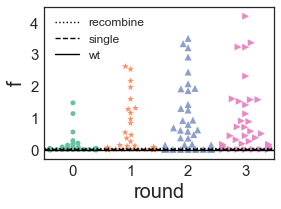

In [143]:
pal = sns.color_palette('Set2')
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
for mark, r in zip(['o', '*', '^', '>'], range(4)):
    dat = df[df['round'] == r]
    temp = pd.DataFrame(np.array([[0, 1, 2, 3]]).T, columns=['round'])
    dat = dat.append(temp)
    if r == 0:
        s = 5
    else:
        s = 7
    ax = sns.swarmplot(data=dat, x='round', y='f', color=pal[r], ax=ax, zorder=0, marker=mark, size=s)

_ = ax.plot([-0.5, 3.5], [df[df['baseline'] == 1]['f'].values] * 2, ':', label='recombine', color='black')
_ = ax.plot([-0.5, 3.5], [np.max(10 ** y[single_inds])] * 2, '--', color='black', label='single')
_ = ax.plot([-0.5, 3.5], [np.max(10 ** y[wt_inds])] * 2, color='black', label='wt')
_ = ax.legend()


_ = fig.tight_layout()
_ = fig.savefig('../outputs/gb1_batches.pdf')

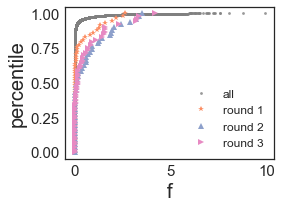

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
f = df['f'].values
p = df['sorted'].values
inds = list(np.argsort(f))
thinned = inds[:-1000:10] + inds[-1000:]
f_thinned = f[thinned] 
p_thinned = p[thinned] 
_ = ax.plot(f_thinned, p_thinned, '.', color='grey', alpha=0.8, label='all')
for c, r, s in zip(pal[1:], range(1, 4), ['*', '^', '>']):
    df_ = df[df['round'] == r]
    _ = ax.plot(np.sort(df_['f']), np.linspace(0, 1, len(df_)), s, label='round ' + str(r), 
                color=c)
_ = ax.legend()
_ = ax.set_xlabel('f')
_ = ax.set_ylabel('percentile')
_ = fig.tight_layout()
_ = fig.savefig('../outputs/gb1_ecdf.pdf')

In [4]:
np.random.seed(125120)
_ = torch.manual_seed(43298)



n = 100

singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
wt_inds = [seq_to_x[wt]]
single_inds = wt_inds + [seq_to_x[seq] for seq in singles]
train_inds = wt_inds + list(np.random.choice(len(X), n, replace=True)) # + single_inds


y_true = y
A_test = A

sampled_inds = [train_inds[:]]
libs = []
objs = []

rounds = 400 // n - 1

for it in range(3):
    inds = sorted(set(train_inds))
    print(len(inds))
    dic, _ = helpers.get_predictions(A[inds], y[inds], A_test,
                                     one_hots=X, its=3000, lr=1e-2)
    print()
    seen_seqs = [helpers.decode_X(X[i]) for i in inds]
    for s in seen_seqs:
        dic[s] = 0.0
    seed = helpers.get_seed(dic)
    sets_seed, objs_seed = opt.greedy(ground, seed, objectives.objective, depth=1, obj_args=(L, dic, n))
    sets_grou, objs_grou = opt.greedy(ground, ground, objectives.objective, depth=1, obj_args=(L, dic, n))
    if objs_grou[-1] < objs_seed[-1]:
        X_new = sets_grou[-1]
        objs.append(objs_grou[-1])
    else:
        X_new = sets_seed[-1]
        objs.append(objs_seed[-1])
    new_lib = helpers.seqs_from_set(X_new, L)
    inds = np.random.choice(len(new_lib), n, replace=True)
    sampled_seqs = [new_lib[i] for i in inds]
    inds = [seq_to_x[s] for s in sampled_seqs]
    sampled_inds.append(inds)
    train_inds += inds
    libs.append(X_new)
    
    

101
Iteration 3000 of 3000	NLML: 50.0934	sn: 0.499694	
201
Iteration 3000 of 3000	NLML: 97.1421	sn: 0.507074	
264
Iteration 3000 of 3000	NLML: 58.3521	sn: 0.029786	


In [5]:
df = pd.DataFrame(10 ** y, columns=['f'])
df['round'] = [-1 for _ in df.index]
for r, inds in enumerate(sampled_inds):
    for i in inds:
        if df.loc[i, 'round'] == -1:
            df.loc[i, 'round'] = r

df['single'] = [1 if i in single_inds else 0 for i in df.index]
df['wt'] = [0 for i in df.index]
df.loc[wt_inds]['wt'] = 1
df['sorted'] = np.linspace(0, 1, len(y))[np.argsort(np.argsort(df['f']))]
df['baseline'] = [0 for _ in df.index]
baseline = ''
for i in range(4):
    seqs = [wt[:i] + a + wt[i + 1:] for a in aas]
    inds = [seq_to_x[s] for s in seqs]
    baseline += aas[np.argmax(y[inds])]
df.loc[seq_to_x[baseline], 'baseline'] = 1

In [8]:
results = {
    'df':df,
    'sampled_inds': sampled_inds,
    'libs':libs,
    'objs': objs
}

with open('../outputs/20181018_gb1_batches4.pkl', 'wb') as f:
    pickle.dump(results, f)

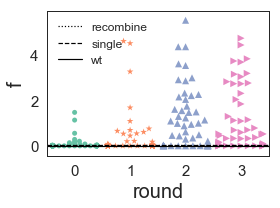

In [7]:
pal = sns.color_palette('Set2')
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
for mark, r in zip(['o', '*', '^', '>'], range(4)):
    dat = df[df['round'] == r]
    temp = pd.DataFrame(np.array([[0, 1, 2, 3]]).T, columns=['round'])
    dat = dat.append(temp)
    if r == 0:
        s = 5
    else:
        s = 7
    ax = sns.swarmplot(data=dat, x='round', y='f', color=pal[r], ax=ax, zorder=0, marker=mark, size=s)

_ = ax.plot([-0.5, 3.5], [df[df['baseline'] == 1]['f'].values] * 2, ':', label='recombine', color='black')
_ = ax.plot([-0.5, 3.5], [np.max(10 ** y[single_inds])] * 2, '--', color='black', label='single')
_ = ax.plot([-0.5, 3.5], [np.max(10 ** y[wt_inds])] * 2, color='black', label='wt')
_ = ax.legend(frameon=False)


_ = fig.tight_layout()
_ = fig.savefig('../outputs/gb1_batches4.pdf')

In [13]:
np.random.seed(125120)
_ = torch.manual_seed(43298)



n = 200

singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
wt_inds = [seq_to_x[wt]]
single_inds = wt_inds + [seq_to_x[seq] for seq in singles]
train_inds = wt_inds + list(np.random.choice(len(X), n, replace=True)) # + single_inds


y_true = y
A_test = A

sampled_inds = [train_inds[:]]
libs = []
objs = []

rounds = 400 // n - 1

for it in range(rounds):
    inds = sorted(set(train_inds))
    print(len(inds))
    dic, _ = helpers.get_predictions(A[inds], y[inds], A_test,
                                     one_hots=X, its=3000, lr=1e-2)
    print()
    seen_seqs = [helpers.decode_X(X[i]) for i in inds]
    for s in seen_seqs:
        dic[s] = 0.0
    seed = helpers.get_seed(dic)
    sets_seed, objs_seed = opt.greedy(ground, seed, objectives.objective, depth=1, obj_args=(L, dic, n))
    sets_grou, objs_grou = opt.greedy(ground, ground, objectives.objective, depth=1, obj_args=(L, dic, n))
    if objs_grou[-1] < objs_seed[-1]:
        X_new = sets_grou[-1]
        objs.append(objs_grou[-1])
    else:
        X_new = sets_seed[-1]
        objs.append(objs_seed[-1])
    new_lib = helpers.seqs_from_set(X_new, L)
    inds = np.random.choice(len(new_lib), n, replace=True)
    sampled_seqs = [new_lib[i] for i in inds]
    inds = [seq_to_x[s] for s in sampled_seqs]
    sampled_inds.append(inds)
    train_inds += inds
    libs.append(X_new)
    
df = pd.DataFrame(10 ** y, columns=['f'])
df['round'] = [-1 for _ in df.index]
for r, inds in enumerate(sampled_inds):
    for i in inds:
        if df.loc[i, 'round'] == -1:
            df.loc[i, 'round'] = r

df['single'] = [1 if i in single_inds else 0 for i in df.index]
df['wt'] = [0 for i in df.index]
df.loc[wt_inds]['wt'] = 1
df['sorted'] = np.linspace(0, 1, len(y))[np.argsort(np.argsort(df['f']))]
df['baseline'] = [0 for _ in df.index]
baseline = ''
for i in range(4):
    seqs = [wt[:i] + a + wt[i + 1:] for a in aas]
    inds = [seq_to_x[s] for s in seqs]
    baseline += aas[np.argmax(y[inds])]
df.loc[seq_to_x[baseline], 'baseline'] = 1
    
results = {
    'df':df,
    'sampled_inds': sampled_inds,
    'libs':libs,
    'objs': objs
}

with open('../outputs/20181018_gb1_batches' + str(rounds + 1) + '.pkl', 'wb') as f:
    pickle.dump(results, f)
    
    

201
Iteration 3000 of 3000	NLML: 98.1010	sn: 0.422936	


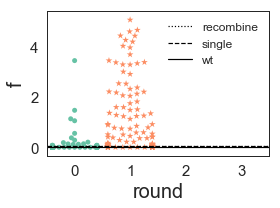

In [14]:
pal = sns.color_palette('Set2')
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
for mark, r in zip(['o', '*', '^', '>'], range(4)):
    dat = df[df['round'] == r]
    temp = pd.DataFrame(np.array([[0, 1, 2, 3]]).T, columns=['round'])
    dat = dat.append(temp)
    if r == 0:
        s = 5
    else:
        s = 7
    ax = sns.swarmplot(data=dat, x='round', y='f', color=pal[r], ax=ax, zorder=0, marker=mark, size=s)

_ = ax.plot([-0.5, 3.5], [df[df['baseline'] == 1]['f'].values] * 2, ':', label='recombine', color='black')
_ = ax.plot([-0.5, 3.5], [np.max(10 ** y[single_inds])] * 2, '--', color='black', label='single')
_ = ax.plot([-0.5, 3.5], [np.max(10 ** y[wt_inds])] * 2, color='black', label='wt')
_ = ax.legend(frameon=False)


_ = fig.tight_layout()
_ = fig.savefig('../outputs/gb1_batches' + str(rounds + 1) + '.pdf')

In [51]:


for n in [50]:
    np.random.seed(12520)
    _ = torch.manual_seed(4329)




    singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
    wt_inds = [seq_to_x[wt]]
    single_inds = wt_inds + [seq_to_x[seq] for seq in singles]
    train_inds = wt_inds + list(np.random.choice(len(X), n, replace=True)) # + single_inds


    y_true = y
    A_test = A

    sampled_inds = [train_inds[:]]
    libs = []
    objs = []

    rounds = 400 // n - 1

    for it in range(rounds):
        inds = sorted(set(train_inds))
        print(len(inds))
        dic, _ = helpers.get_predictions(A[inds], y[inds], A_test,
                                         one_hots=X, its=3000, lr=1e-2)
        print()
        seen_seqs = [helpers.decode_X(X[i]) for i in inds]
        for s in seen_seqs:
            dic[s] = 0.0
        seed = helpers.get_seed(dic)
        sets_seed, objs_seed = opt.greedy(ground, seed, objectives.objective, depth=1, obj_args=(L, dic, n))
        sets_grou, objs_grou = opt.greedy(ground, ground, objectives.objective, depth=1, obj_args=(L, dic, n))
        if objs_grou[-1] < objs_seed[-1]:
            X_new = sets_grou[-1]
            objs.append(objs_grou[-1])
        else:
            X_new = sets_seed[-1]
            objs.append(objs_seed[-1])
        new_lib = helpers.seqs_from_set(X_new, L)
        inds = np.random.choice(len(new_lib), n, replace=True)
        sampled_seqs = [new_lib[i] for i in inds]
        inds = [seq_to_x[s] for s in sampled_seqs]
        sampled_inds.append(inds)
        train_inds += inds
        libs.append(X_new)

    df = pd.DataFrame(10 ** y, columns=['f'])
    df['round'] = [-1 for _ in df.index]
    for r, inds in enumerate(sampled_inds):
        for i in inds:
            if df.loc[i, 'round'] == -1:
                df.loc[i, 'round'] = r

    df['single'] = [1 if i in single_inds else 0 for i in df.index]
    df['wt'] = [0 for i in df.index]
    df.loc[wt_inds]['wt'] = 1
    df['sorted'] = np.linspace(0, 1, len(y))[np.argsort(np.argsort(df['f']))]
    df['baseline'] = [0 for _ in df.index]
    baseline = ''
    for i in range(4):
        seqs = [wt[:i] + a + wt[i + 1:] for a in aas]
        inds = [seq_to_x[s] for s in seqs]
        baseline += aas[np.argmax(y[inds])]
    df.loc[seq_to_x[baseline], 'baseline'] = 1

    results = {
        'df':df,
        'sampled_inds': sampled_inds,
        'libs':libs,
        'objs': objs
    }

    with open('../outputs/20181018_gb1_batches' + str(rounds + 1) + '.pkl', 'wb') as f:
        pickle.dump(results, f)

    

51
Iteration 3000 of 3000	NLML: 25.5000	sn: 0.050000	
100
Iteration 3000 of 3000	NLML: 50.0000	sn: 0.050000	
150
Iteration 3000 of 3000	NLML: 75.0000	sn: 0.050000	
200
Iteration 3000 of 3000	NLML: 100.0000	sn: 0.050000	
250
Iteration 3000 of 3000	NLML: 109.2959	sn: 0.432722	
277
Iteration 3000 of 3000	NLML: 40.3614	sn: 0.000001	
310
Iteration 3000 of 3000	NLML: -29.7098	sn: 0.000001	


In [57]:
df = pd.DataFrame(10 ** y, columns=['f'])
ns = [10, 50, 75, 100, 200]

for n in ns:
    col = 'round' + str(n)
    df[col] = [-1 for _ in df.index]
    rounds = 400 // n - 1
    with open('../outputs/20181018_gb1_batches' + str(rounds + 1) + '.pkl', 'rb') as f:
        results = pickle.load(f)
    for r, inds in enumerate(results['sampled_inds']):
        for i in inds:
            if df.loc[i, col] == -1:
                df.loc[i, col] = r
        
df['single'] = [1 if i in single_inds else 0 for i in df.index]
df['wt'] = [0 for i in df.index]
df.loc[wt_inds]['wt'] = 1
df['sorted'] = np.linspace(0, 1, len(y))[np.argsort(np.argsort(df['f']))]
df['baseline'] = [0 for _ in df.index]
baseline = ''
for i in range(4):
    seqs = [wt[:i] + a + wt[i + 1:] for a in aas]
    inds = [seq_to_x[s] for s in seqs]
    baseline += aas[np.argmax(y[inds])]
df.loc[seq_to_x[baseline], 'baseline'] = 1

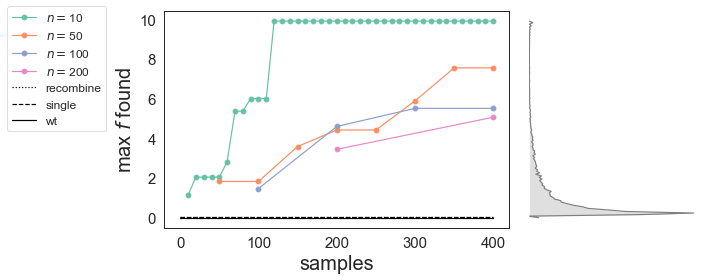

In [58]:
pal = sns.color_palette('Set2')
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios':[2, 1]}, figsize=(10, 4))


ax = axs[1]
f = df['f'].values
p = df['sorted'].values
inds = list(np.argsort(f))
thinned = inds[:-1000:10] + inds[-1000:]
f_thinned = f[thinned] 
p_thinned = p[thinned] 
_ = sns.kdeplot(f, vertical=True, shade=True, color='grey')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_axis_off()


ax = axs[0]

for n, c in zip([10, 50, 100, 200], pal):
    col = 'round' + str(n)
    dat = df[df[col] != -1]
    rounds = np.array(sorted(set(df[col]))[1:])
    rounds += 1
    xs = n * rounds
    ys = [np.max(dat[dat[col] <= r - 1]['f'].values) for r in rounds]
    ax.plot(xs, ys, 'o-', label=r'$n=$' + str(n), color=c)
    

_ = ax.plot([-0.5, 400], [df[df['baseline'] == 1]['f'].values] * 2, ':', label='recombine', color='black')
_ = ax.plot([-0.5, 400], [np.max(10 ** y[single_inds])] * 2, '--', color='black', label='single')
_ = ax.plot([-0.5, 400], [np.max(10 ** y[wt_inds])] * 2, color='black', label='wt')


ax.legend(bbox_to_anchor=(-0.15, 1.05))
_ = ax.set_xlabel('samples')
_ = ax.set_ylabel(r'max $f$ found')
_ = fig.tight_layout()
_ = fig.savefig('../outputs/gb1_maxes.pdf')

In [64]:


for n in [10]:
    np.random.seed(125120)
    _ = torch.manual_seed(43298)




    singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
    wt_inds = [seq_to_x[wt]]
    single_inds = wt_inds + [seq_to_x[seq] for seq in singles]
    train_inds = wt_inds + list(np.random.choice(len(X), n, replace=True)) # + single_inds


    y_true = y
    A_test = A

    sampled_inds = [train_inds[:]]
    libs = []
    objs = []

    rounds = 400 // n - 1

    for it in range(rounds):
        inds = sorted(set(train_inds))
        print(len(inds))
        dic, _ = helpers.get_predictions(A[inds], y[inds], A_test,
                                         one_hots=X, its=3000, lr=1e-2)
        print()
        seen_seqs = [helpers.decode_X(X[i]) for i in inds]
        for s in seen_seqs:
            dic[s] = 0.0
        seed = helpers.get_seed(dic)
        sets_seed, objs_seed = opt.greedy_add(ground, seed, objectives.objective, obj_args=(L, dic, n))
        sets_grou, objs_grou = opt.greedy_add(ground, ground, objectives.objective, obj_args=(L, dic, n))
        if objs_grou[-1] < objs_seed[-1]:
            X_new = sets_grou[-1]
            objs.append(objs_grou[-1])
        else:
            X_new = sets_seed[-1]
            objs.append(objs_seed[-1])
        new_lib = helpers.seqs_from_set(X_new, L)
        inds = np.random.choice(len(new_lib), n, replace=True)
        sampled_seqs = [new_lib[i] for i in inds]
        inds = [seq_to_x[s] for s in sampled_seqs]
        sampled_inds.append(inds)
        train_inds += inds
        libs.append(X_new)

    df = pd.DataFrame(10 ** y, columns=['f'])
    df['round'] = [-1 for _ in df.index]
    for r, inds in enumerate(sampled_inds):
        for i in inds:
            if df.loc[i, 'round'] == -1:
                df.loc[i, 'round'] = r

    df['single'] = [1 if i in single_inds else 0 for i in df.index]
    df['wt'] = [0 for i in df.index]
    df.loc[wt_inds]['wt'] = 1
    df['sorted'] = np.linspace(0, 1, len(y))[np.argsort(np.argsort(df['f']))]
    df['baseline'] = [0 for _ in df.index]
    baseline = ''
    for i in range(4):
        seqs = [wt[:i] + a + wt[i + 1:] for a in aas]
        inds = [seq_to_x[s] for s in seqs]
        baseline += aas[np.argmax(y[inds])]
    df.loc[seq_to_x[baseline], 'baseline'] = 1

    results = {
        'df':df,
        'sampled_inds': sampled_inds,
        'libs':libs,
        'objs': objs
    }

    with open('../outputs/20181018_gb1_batches_add' + str(rounds + 1) + '.pkl', 'wb') as f:
        pickle.dump(results, f)

    

11
Iteration 3000 of 3000	NLML: 5.5000	sn: 0.050000	
21
Iteration 3000 of 3000	NLML: 10.5000	sn: 0.049998	
31
Iteration 3000 of 3000	NLML: 15.4909	sn: 0.000001	
39
Iteration 3000 of 3000	NLML: 17.2140	sn: 0.000001	
47
Iteration 3000 of 3000	NLML: 12.1602	sn: 0.000001	
54
Iteration 3000 of 3000	NLML: 4.5196	sn: 0.004433	
60
Iteration 3000 of 3000	NLML: -0.3446	sn: 0.008553	
67
Iteration 3000 of 3000	NLML: 0.0804	sn: 0.005970	
74
Iteration 3000 of 3000	NLML: 0.0231	sn: 0.004879	
81
Iteration 3000 of 3000	NLML: -3.5154	sn: 0.004339	
90
Iteration 3000 of 3000	NLML: -7.8988	sn: 0.002197	
96
Iteration 3000 of 3000	NLML: -11.9999	sn: 0.002771	
103
Iteration 3000 of 3000	NLML: -18.0170	sn: 0.004137	
108
Iteration 3000 of 3000	NLML: -23.1995	sn: 0.003421	
114
Iteration 3000 of 3000	NLML: -28.6271	sn: 0.003131	
121
Iteration 3000 of 3000	NLML: -34.6523	sn: 0.003493	
129
Iteration 3000 of 3000	NLML: -41.5832	sn: 0.003616	
134
Iteration 3000 of 3000	NLML: -44.7782	sn: 0.003423	
141
Iteration 3000 

In [65]:


for n in [10]:
    np.random.seed(125120)
    _ = torch.manual_seed(43298)




    singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
    wt_inds = [seq_to_x[wt]]
    single_inds = wt_inds + [seq_to_x[seq] for seq in singles]
    train_inds = wt_inds + list(np.random.choice(len(X), n, replace=True)) # + single_inds


    y_true = y
    A_test = A

    sampled_inds = [train_inds[:]]
    libs = []
    objs = []

    rounds = 400 // n - 1

    for it in range(rounds):
        inds = sorted(set(train_inds))
        print(len(inds))
        dic, _ = helpers.get_predictions(A[inds], y[inds], A_test,
                                         one_hots=X, its=3000, lr=1e-2)
        print()
        seen_seqs = [helpers.decode_X(X[i]) for i in inds]
        for s in seen_seqs:
            dic[s] = 0.0
        seed = helpers.get_seed(dic)
        sets_seed, objs_seed = opt.greedy_add(ground, seed, objectives.objective, obj_args=(L, dic, n), remove=True)
        sets_grou, objs_grou = opt.greedy_add(ground, ground, objectives.objective, obj_args=(L, dic, n), remove=True)
        if objs_grou[-1] < objs_seed[-1]:
            X_new = sets_grou[-1]
            objs.append(objs_grou[-1])
        else:
            X_new = sets_seed[-1]
            objs.append(objs_seed[-1])
        new_lib = helpers.seqs_from_set(X_new, L)
        inds = np.random.choice(len(new_lib), n, replace=True)
        sampled_seqs = [new_lib[i] for i in inds]
        inds = [seq_to_x[s] for s in sampled_seqs]
        sampled_inds.append(inds)
        train_inds += inds
        libs.append(X_new)

    df = pd.DataFrame(10 ** y, columns=['f'])
    df['round'] = [-1 for _ in df.index]
    for r, inds in enumerate(sampled_inds):
        for i in inds:
            if df.loc[i, 'round'] == -1:
                df.loc[i, 'round'] = r

    df['single'] = [1 if i in single_inds else 0 for i in df.index]
    df['wt'] = [0 for i in df.index]
    df.loc[wt_inds]['wt'] = 1
    df['sorted'] = np.linspace(0, 1, len(y))[np.argsort(np.argsort(df['f']))]
    df['baseline'] = [0 for _ in df.index]
    baseline = ''
    for i in range(4):
        seqs = [wt[:i] + a + wt[i + 1:] for a in aas]
        inds = [seq_to_x[s] for s in seqs]
        baseline += aas[np.argmax(y[inds])]
    df.loc[seq_to_x[baseline], 'baseline'] = 1

    results = {
        'df':df,
        'sampled_inds': sampled_inds,
        'libs':libs,
        'objs': objs
    }

    with open('../outputs/20181018_gb1_batches_rem' + str(rounds + 1) + '.pkl', 'wb') as f:
        pickle.dump(results, f)

    

11
Iteration 3000 of 3000	NLML: 5.5000	sn: 0.050000	
21
Iteration 3000 of 3000	NLML: 10.5000	sn: 0.050000	
31
Iteration 3000 of 3000	NLML: 15.4862	sn: 0.000001	
37
Iteration 3000 of 3000	NLML: 16.4605	sn: 0.000001	
40
Iteration 3000 of 3000	NLML: 14.1486	sn: 0.000001	
46
Iteration 3000 of 3000	NLML: 8.4805	sn: 0.037625	
50
Iteration 3000 of 3000	NLML: 5.0348	sn: 0.036435	
57
Iteration 3000 of 3000	NLML: 11.2721	sn: 0.093821	
65
Iteration 3000 of 3000	NLML: 18.3234	sn: 0.138697	
71
Iteration 3000 of 3000	NLML: 16.6709	sn: 0.129323	
80
Iteration 3000 of 3000	NLML: 6.6133	sn: 0.063312	
86
Iteration 3000 of 3000	NLML: -0.2113	sn: 0.041367	
96
Iteration 3000 of 3000	NLML: 4.7850	sn: 0.043725	
103
Iteration 3000 of 3000	NLML: -1.3751	sn: 0.033573	
111
Iteration 3000 of 3000	NLML: -9.7252	sn: 0.018029	
120
Iteration 3000 of 3000	NLML: -17.3471	sn: 0.014068	
128
Iteration 3000 of 3000	NLML: -25.0853	sn: 0.009516	
136
Iteration 3000 of 3000	NLML: -27.3962	sn: 0.003199	
143
Iteration 3000 of 300

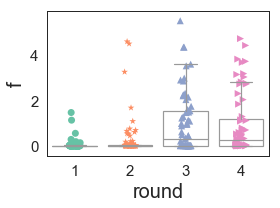

In [94]:
pal = sns.color_palette('Set2')

fnames = ['../outputs/20181018_gb1_batches4.pkl']

out_names = ['dsopt']
for out_name, fname in zip(out_names, fnames):
    with open(fname, 'rb') as f:
        results = pickle.load(f)
    df = results['df']
    df['round'] += 1

    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    for mark, r in zip(['o', '*', '^', '>'], range(1, 5)):
        dat = df[df['round'] == r]
        temp = pd.DataFrame(np.array([[1, 2, 3, 4]]).T, columns=['round'])
        dat = dat.append(temp)
        if r == 0:
            s = 5
        else:
            s = 7
        ax = sns.boxplot(data=dat, x='round', y='f', color='white', ax=ax, fliersize=0)
        ax = sns.stripplot(data=dat, x='round', y='f', color=pal[r-1], ax=ax, marker=mark, size=s, zorder=1)

#     _ = ax.plot([-0.5, 3.5], [df[df['baseline'] == 1]['f'].values] * 2, ':', label='recombine', color='black')
#     _ = ax.plot([-0.5, 3.5], [np.max(10 ** y[single_inds])] * 2, '--', color='black', label='single')
#     _ = ax.plot([-0.5, 3.5], [np.max(10 ** y[wt_inds])] * 2, color='black', label='wt')
#     _ = ax.legend(frameon=True)
    _ = fig.tight_layout()
    _ = fig.savefig('../outputs/gb1_batches' + out_name + '.pdf')